In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

#garbage collector to keep RAM in check
import gc 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jane-street-real-time-market-data-forecasting/responders.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/sample_submission.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/features.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=4/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=5/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=6/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=3/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=1/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=8/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=2/part-0.parquet
/kaggle/input/jane-street-real-time-market

## Data Discovery

```responders.csv``` - metadata pertaining to the anonymized responders

```responder_{0...8}``` - Anonymized responders clipped between -5 and 5. The ```responder_6``` field is what you are trying to predict.


In [9]:
resp = pd.read_csv('/kaggle/input/jane-street-real-time-market-data-forecasting/responders.csv')
resp

,responder,tag_0,tag_1,tag_2,tag_3,tag_4
0,responder_0,True,False,True,False,False
1,responder_1,True,False,False,True,False
2,responder_2,True,True,False,False,False
3,responder_3,False,False,True,False,True
4,responder_4,False,False,False,True,True
5,responder_5,False,True,False,False,True
6,responder_6,False,False,True,False,False
7,responder_7,False,False,False,True,False
8,responder_8,False,True,False,False,False


```features.csv``` - metadata pertaining to the anonymized features

```feature_{00...78}``` - Anonymized market data.

In [10]:
feat = pd.read_csv('/kaggle/input/jane-street-real-time-market-data-forecasting/features.csv', index_col=0)
feat

,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,tag_11,tag_12,tag_13,tag_14,tag_15,tag_16
feature,,,,,,,,,,,,,,,,,
feature_00,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,True
feature_01,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True,False,True
feature_02,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True
feature_03,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True
feature_04,False,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feature_74,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False
feature_75,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False
feature_76,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False


In [13]:
#By Safadoost
#encode the boolean  True/False to plot a heatmap after

categorical_columns = feat[:]
# Create a new column for each unique value in the categorical columns.
df_categorical = pd.get_dummies(
    data = feat ,
    #prefix = 'OHE' ,  # One hot encoding
    #prefix_sep = '_' ,
    columns = categorical_columns ,
    #drop_first = True ,
    dtype = 'int8'
)

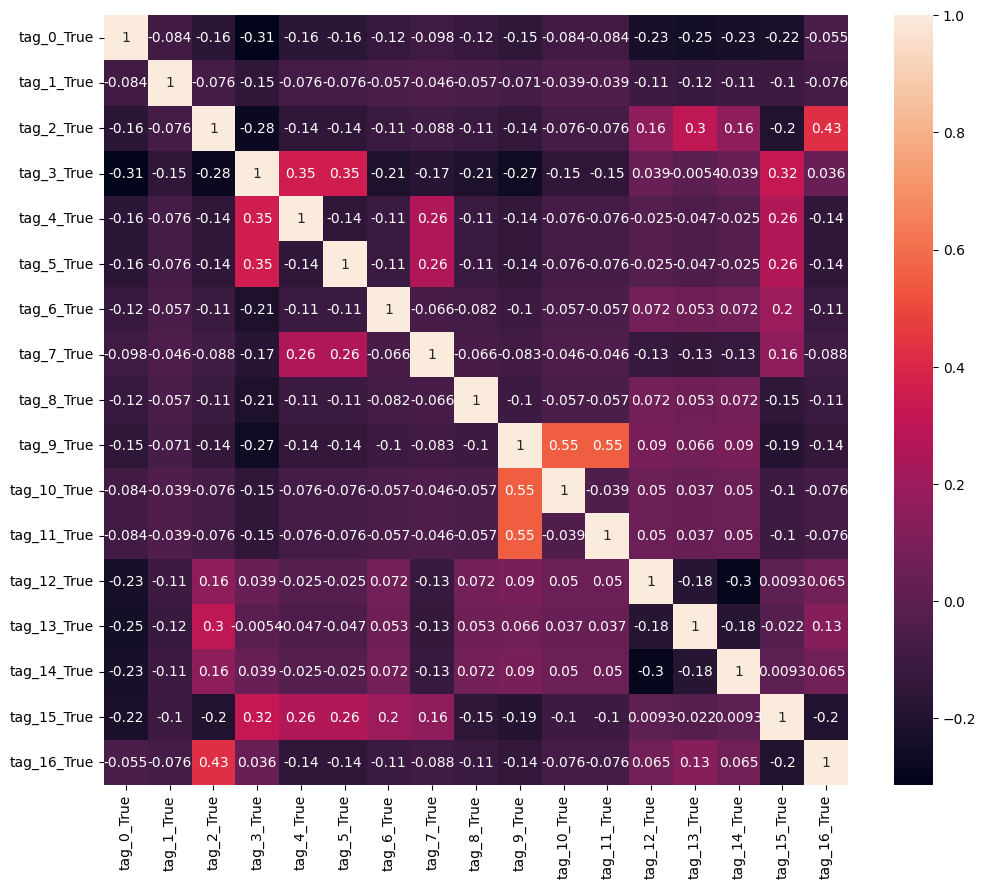

In [14]:
plt.figure(figsize=(12,10))
sns.heatmap(df_categorical.corr(),annot=True);

```train.parquet``` - The training set, contains historical data and returns. For convenience, the training set has been partitioned into ten parts.

* ```date_id``` and ```time_id``` - Integer values that are ordinally sorted, providing a chronological structure to the data, although the actual time intervals between ```time_id``` values may vary.
* ```symbol_id``` - Identifies a unique financial instrument.
* ```weight``` - The weighting used for calculating the scoring function.

Each row in the ```{train/test}.parquet``` dataset corresponds to a unique combination of a symbol (identified by ```symbol_id```) and a timestamp (represented by ```date_id``` and ```time_id```). You will be provided with multiple responders, with ```responder_6``` being the only responder used for scoring. The date_id column is an integer which represents the day of the event, while ```time_id``` represents a time ordering. It's important to note that the real time differences between each ```time_id``` are not guaranteed to be consistent.

The ```symbol_id``` column contains encrypted identifiers. Each ```symbol_id``` is not guaranteed to appear in all ```time_id``` and ```date_id``` combinations. Additionally, new ```symbol_id``` values may appear in future test sets.

Now we discover one parquet file ```partition_id=0/part-0.parquet```

In [2]:
train_data = pd.read_parquet("/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=4/part-0.parquet")
train_data

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
0,680,0,0,2.298160,0.851814,1.197591,0.219422,0.411698,2.057359,-0.542597,...,-0.195100,-0.304665,0.164485,-0.205231,0.191064,-1.413209,0.375675,0.929775,-1.574939,1.101371
1,680,0,1,3.928745,0.534441,1.079740,0.038748,0.275343,2.135057,-0.541966,...,-0.470271,0.089769,0.011395,0.092348,0.473781,0.397024,0.777026,0.826995,0.569681,1.986971
2,680,0,2,1.340433,-0.227643,0.764146,-0.243349,0.247027,2.347248,-0.478477,...,0.152837,0.218281,0.060373,-0.164715,-0.132612,0.543831,-0.123519,-0.296969,0.547286,-0.049303
3,680,0,3,1.695526,0.267686,1.193612,-0.388798,0.030673,2.175273,-0.408371,...,11.179185,-0.012298,1.047678,-0.696032,0.960062,2.328890,0.718955,2.047506,3.691308,3.031337
4,680,0,5,2.700766,0.952372,0.861269,-0.375405,0.259099,2.497325,-0.618828,...,-0.770234,-0.229585,-0.240741,-0.887929,-0.061485,0.691569,1.016049,0.103898,0.814866,2.073280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5022947,849,967,34,1.320814,-1.135969,-1.610122,-1.160252,-1.541175,-0.177305,-0.503478,...,0.044115,1.111880,-1.623336,-2.352973,0.618814,0.261707,-1.148116,0.019118,0.035589,0.021048
5022948,849,967,35,1.478998,-1.805648,-2.178270,-1.376917,-1.692970,-0.505028,-0.422419,...,-0.230330,0.765486,1.303708,5.000000,-0.073899,-0.051414,1.282058,-0.010037,0.025545,-0.050791
5022949,849,967,36,1.145991,-1.962125,-1.765331,-1.641831,-1.397208,-0.210446,-0.322906,...,-0.331187,-0.008548,0.156050,-5.000000,-0.262077,-0.118867,-1.348349,0.015093,0.027283,0.014007
5022950,849,967,37,1.624830,-1.603198,-1.990240,-0.389927,-1.518245,-0.720761,-0.280535,...,-0.131612,0.967296,-0.007091,0.974733,-0.718463,-0.329689,-0.213125,-0.229978,-0.082040,-0.438307


In [4]:
# checking data type
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5022952 entries, 0 to 5022951
Data columns (total 92 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date_id      int16  
 1   time_id      int16  
 2   symbol_id    int8   
 3   weight       float32
 4   feature_00   float32
 5   feature_01   float32
 6   feature_02   float32
 7   feature_03   float32
 8   feature_04   float32
 9   feature_05   float32
 10  feature_06   float32
 11  feature_07   float32
 12  feature_08   float32
 13  feature_09   int8   
 14  feature_10   int8   
 15  feature_11   int16  
 16  feature_12   float32
 17  feature_13   float32
 18  feature_14   float32
 19  feature_15   float32
 20  feature_16   float32
 21  feature_17   float32
 22  feature_18   float32
 23  feature_19   float32
 24  feature_20   float32
 25  feature_21   float32
 26  feature_22   float32
 27  feature_23   float32
 28  feature_24   float32
 29  feature_25   float32
 30  feature_26   float32
 31  feature_27   float32
 32

In [16]:
# Calculate the number of missing values for each feature
missing_data = train_data.isna().sum()

# Filter out features with no missing values and sort by missing values in descending order
missing_data_sorted = missing_data[missing_data > 0].sort_values(ascending=False)

# Display the sorted result
print(missing_data_sorted)

feature_39    353062
feature_42    353062
feature_53    352852
feature_50    352852
feature_15    124539
feature_44     93611
feature_41     93611
feature_55     93402
feature_52     93402
feature_73     50457
feature_74     50457
feature_32     49192
feature_33     49192
feature_58     49192
feature_21     22264
feature_26     22264
feature_31     22264
feature_27     22264
feature_17     20763
feature_76      9743
feature_75      9743
feature_66      6375
feature_65      6375
feature_46      6375
feature_45      6375
feature_77      6199
feature_78      6199
feature_62      3910
feature_64      2241
feature_63      1943
feature_43       287
feature_40       287
feature_16         6
feature_57         4
feature_56         4
feature_19         4
feature_18         4
dtype: int64


In [19]:
print(f"number of features having missing data: {missing_data_sorted.count()}")
print(f"total number of missing data: {missing_data_sorted.sum()}")

number of features having missing data: 37
total number of missing data: 2334776


There are quite a many variables with missing values here (37/92); however, we will conduct exploratory analysis to determine if these variables affect the model before handling the missing values. If they do not impact the prediction model for the target variable, we do not need to address them.

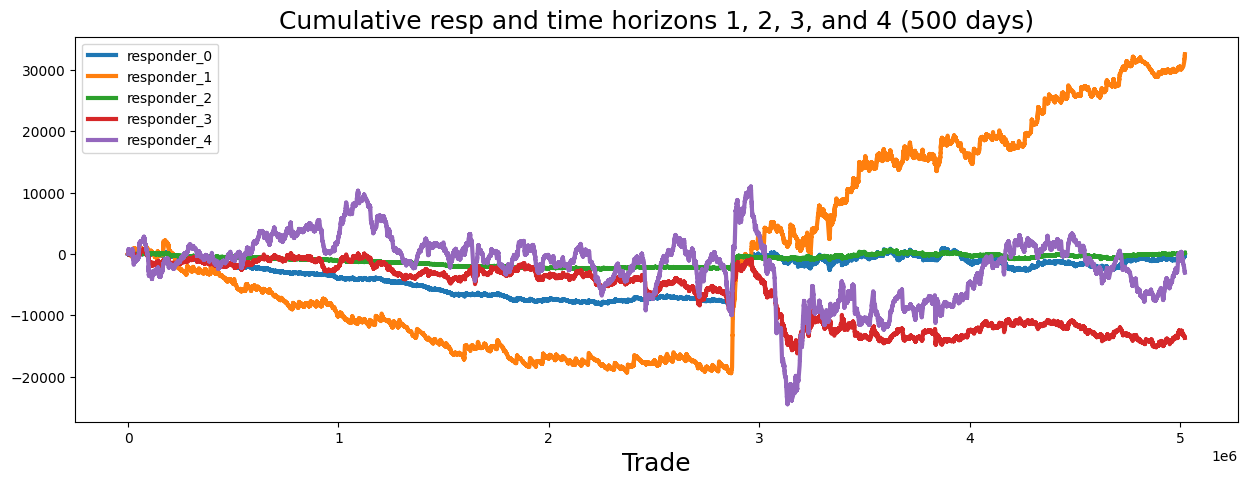

In [21]:
#By Carl McBride Ellis https://www.kaggle.com/code/carlmcbrideellis/jane-street-eda-of-day-0-and-feature-importance/notebook

fig, ax = plt.subplots(figsize=(15, 5))
balance= pd.Series(train_data['responder_0']).cumsum()
resp_1= pd.Series(train_data['responder_1']).cumsum()
resp_2= pd.Series(train_data['responder_2']).cumsum()
resp_3= pd.Series(train_data['responder_3']).cumsum()
resp_4= pd.Series(train_data['responder_4']).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_title ("Cumulative resp and time horizons 1, 2, 3, and 4 (500 days)", fontsize=18)
balance.plot(lw=3)
resp_1.plot(lw=3)
resp_2.plot(lw=3)
resp_3.plot(lw=3)
resp_4.plot(lw=3)
plt.legend(loc="upper left");
del resp_1
del resp_2
del resp_3
del resp_4
gc.collect();

/tmp/ipykernel_31/2321351393.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(train_data['responder_0'],


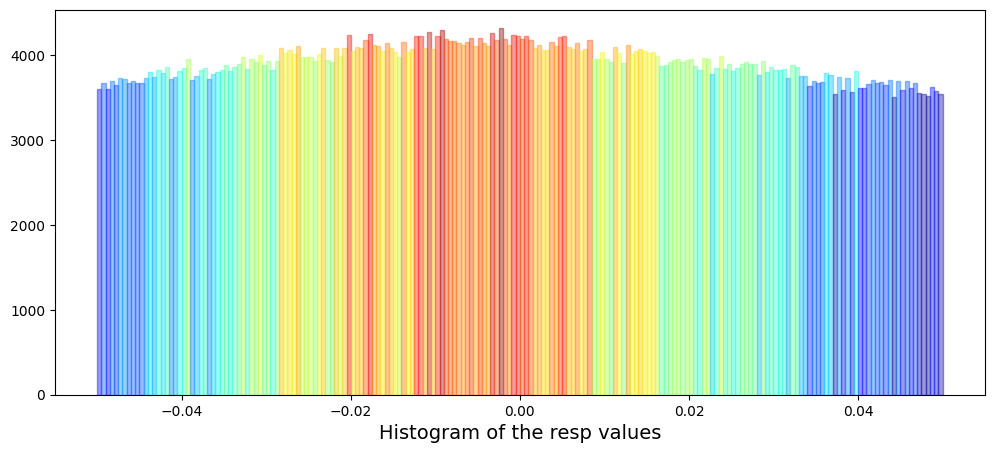

In [25]:
# Plot Histogram of responder_0

plt.figure(figsize = (12,5))
ax = sns.distplot(train_data['responder_0'], 
             bins=200, #Original was 3000 bins
             kde_kws={"clip":(-0.05,0.05)}, 
             hist_kws={"range":(-0.05,0.05)},
             color='darkcyan', 
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of the resp values", size=14)
plt.show();
gc.collect();

responder_0's histogram was a perfect balanced bell-shape. Our value are between -0.05 and 0.05.

In [29]:
min_resp = train_data['responder_0'].min()
print('The minimum value for resp is: %.5f' % min_resp)
max_resp = train_data['responder_0'].max()
print('The maximum value for resp is:  %.5f' % max_resp)

The minimum value for resp is: -5.00000
The maximum value for resp is:  5.00000


## **Skew and Kurtosis of responder_0**

/tmp/ipykernel_31/4251215805.py:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(train_data['responder_0'],


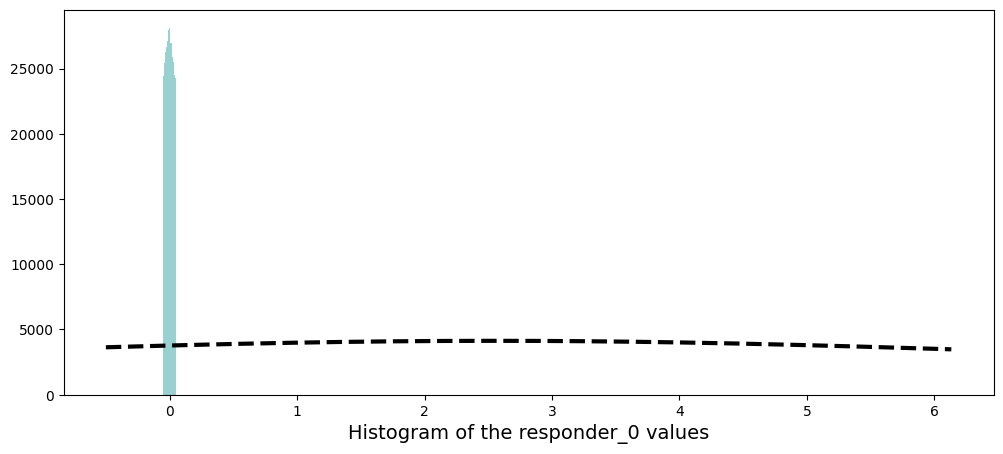

In [30]:
#By Carl Mcbride Ellis https://www.kaggle.com/code/carlmcbrideellis/jane-street-eda-of-day-0-and-feature-importance/notebook

#I don't know why I had to define values again when I tried to change the numbers
#Anyway this line is in every histogram
values = np.array([rec.get_height() for rec in ax.patches])

from scipy.optimize import curve_fit
# the values
x = list(range(len(values)))
x = [((i)-15)/30 for i in x]
y = values

def Lorentzian(x, x0, gamma, A):
    return A * gamma**2/(gamma**2+( x - x0 )**2)

# seed guess
initial_guess=(0, 0.001, 30)

# the fit
parameters,covariance=curve_fit(Lorentzian,x,y,initial_guess)
sigma=np.sqrt(np.diag(covariance))

# and plot
plt.figure(figsize = (12,5))
ax = sns.distplot(train_data['responder_0'], 
             bins=30, 
             kde_kws={"clip":(-0.05,0.05)}, 
             hist_kws={"range":(-0.05,0.05)},
             color='darkcyan', 
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
#norm = plt.Normalize(values.min(), values.max())
#colors = plt.cm.jet(norm(values))
#for rec, col in zip(ax.patches, colors):
#    rec.set_color(col)
plt.xlabel("Histogram of the responder_0 values", size=14)
plt.plot(x,Lorentzian(x,*parameters),'--',color='black',lw=3)
plt.show();
del values
gc.collect();